# Data &Data Technical Challenge

Welcome to the Data&Data technical challenge! We are delighted to offer you the opportunity to show us your skills in the some of technical challenges you may face here at Data&Data. This challenge is **not** about getting the right answer : the most important thing is to show _how_ you think, _how_ you approach problems, and how you code! 

The challenge is based on scraped data from the website www.chrono24.com. In the same directory as this notebook, there is the tab-separated values file called _chrono24_scraped_data.tsv_. This file shall be used for the analysis. There is a second file, _references.tsv_ , containing references codes for watches, which should be used when instructed in the questions below. Good luck!

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [109]:
chrono_df = pd.read_csv("chrono24_scraped_data.tsv", sep='\t')
references_df = pd.read_csv("references.tsv", sep='\t')
chrono_df.head()


condition                    delivery             found_on  \
0       New  Jan 8, 2020 - Jan 20, 2020  2019/12/23 16:06:17   
1    Unworn  Jan 8, 2020 - Jan 20, 2020  2019/12/23 16:06:19   
2    Unworn  Jan 8, 2020 - Jan 20, 2020  2019/12/23 16:06:19   
3    Unworn  Jan 8, 2020 - Jan 20, 2020  2019/12/23 16:06:19   
4    Unworn  Jan 8, 2020 - Jan 20, 2020  2019/12/23 16:06:19   

                    model   price     seller  \
0                  Santos   3,735  12enpunto   
1  Exospace B55 Connected   5,648  12enpunto   
2          Chrono Cockpit   2,598  12enpunto   
3         Tank Américaine  11,885  12enpunto   
4                     NaN   1,698  12enpunto   

                                seller_url  \
0  chrono24.com/dealer/12enpunto/index.htm   
1  chrono24.com/dealer/12enpunto/index.htm   
2  chrono24.com/dealer/12enpunto/index.htm   
3  chrono24.com/dealer/12enpunto/index.htm   
4  chrono24.com/dealer/12enpunto/index.htm   

                                    title  \
0  Cartier W20066D6 Santos Lady Automatic   
1        Breitling Exospace B55 Connected   
2                       Breitling Cockpit   
3         Cartier W2605456 Tank Americano   
4                     Breitling Windrider   

                                                 url            watch_year  \
0  https://www.chrono24.com/cartier/w20066d6-sant...               Unknown   
1  https://www.chrono24.com/breitling/exospace-b5...  2018 (Approximation)   
2  https://www.chrono24.com/breitling/cockpit--id...                  2005   
3  https://www.chrono24.com/cartier/w2605456-tank...               Unknown   
4  https://www.chrono24.com/breitling/windrider--...               Unknown   

                                              raw  
0      Cartier W20066D6 Santos Lady Automatic nan  
1  Breitling Exospace B55 Connected VB5510H2/BE45  
2                    Breitling Cockpit A13358A596  
3                 Cartier W2605456 Tank Americano  
4                      Breitling Windrider B10050

In [110]:
chrono_df = chrono_df[~chrono_df.condition.isna()]
chrono_df.price = pd.to_numeric(chrono_df.price.str.replace(',', '', regex=False), errors='coerce')
chrono_df.found_on = pd.to_datetime(chrono_df.found_on)
references_df = references_df.drop(columns={'Unnamed: 0'})

### 1. How many watch brands are in the file? What are the top 5 brands by number of offers?

the most consistent way i found to find the brand nae is to extract it from the URL

In [111]:
chrono_df['brand'] = chrono_df.url.str.extract(r'com/(.*?)/')
print("we have %i brands in this dataset: \n" % len(chrono_df.brand.unique()), chrono_df.brand.unique())


we have 24 brands in this dataset: 
 ['cartier' 'breitling' 'tagheuer' 'panerai' 'rolex' 'patekphilippe'
 'audemarspiguet' 'omega' 'hublot' 'ulyssenardin' 'franckmuller'
 'baumemercier' 'vacheronconstantin' 'tudor' 'piaget' 'zenith' 'iwc'
 'jaegerlecoultre' 'alangesoehne' 'richardmille' 'longines' 'bulgari'
 'rogerdubuis' 'seiko']


the 5 most frequent brands in our dataset

In [112]:
chrono_df.brand.value_counts(sort=True, ascending=False)[:5]


rolex        9321
omega        6355
breitling    4080
hublot       3443
tagheuer     3287
Name: brand, dtype: int64

## 2. Are these new/unworn or second hand watches?

In [113]:
chrono_df.groupby('condition').size()

condition
New       35880
Unworn     9856
dtype: int64

## 3. Which are the most active sellers on chrono24.com? Are any sellers brand specialists?

I get the number of offers per seller,per brand and also get the total for each seller

In [114]:
sellers_brands = chrono_df.groupby(['seller','brand'], group_keys=False)['url'].count()
sellers_brands = sellers_brands.unstack('brand').fillna(0)
sellers_brands = sellers_brands.astype({col: 'int64' for col in sellers_brands.columns})
sellers_brands['total'] = sellers_brands.sum(axis=1)
sellers_brands = sellers_brands.sort_values('total', ascending=False)


In [115]:
sellers_brands.head(5)

brand                     alangesoehne  audemarspiguet  baumemercier  \
seller                                                                 
Interwatches                         0               1             0   
Prestige Luxusuhren GmbH             0               0             0   
Horando Deutschland GmbH            45               1             0   
Timepiece Perfection                 0              46             0   
CKLY Trading Limited                 0              14             0   

brand                     breitling  bulgari  cartier  franckmuller  hublot  \
seller                                                                        
Interwatches                    194       77      349             0     122   
Prestige Luxusuhren GmbH        441        2        0             0     516   
Horando Deutschland GmbH        201        0       75             0     179   
Timepiece Perfection            106      136      117             0     205   
CKLY Trading Limited             20       52       38            17      89   

brand                     iwc  jaegerlecoultre  ...  richardmille  \
seller                                          ...                 
Interwatches              135              151  ...             0   
Prestige Luxusuhren GmbH    0                0  ...             0   
Horando Deutschland GmbH  103                0  ...             0   
Timepiece Perfection        1               24  ...             0   
CKLY Trading Limited       81               26  ...             0   

brand                     rogerdubuis  rolex  seiko  tagheuer  tudor  \
seller                                                                 
Interwatches                        0   1799      0         8      1   
Prestige Luxusuhren GmbH            0      2      0       412    103   
Horando Deutschland GmbH            0     42      0       266      4   
Timepiece Perfection                0    787      0       158     53   
CKLY Trading Limited                0    210      9       223     91   

brand                     ulyssenardin  vacheronconstantin  zenith  total  
seller                                                                     
Interwatches                       165                   0       0   4594  
Prestige Luxusuhren GmbH           177                   0      50   3013  
Horando Deutschland GmbH            50                  57      82   2018  
Timepiece Perfection                 1                   0     118   1960  
CKLY Trading Limited                18                   8      59   1750  

[5 rows x 25 columns]

TOP 10 most active sellers

In [116]:
sellers_brands['total'].head(10)

seller
Interwatches                4594
Prestige Luxusuhren GmbH    3013
Horando Deutschland GmbH    2018
Timepiece Perfection        1960
CKLY Trading Limited        1750
Fabel-Time GmbH             1691
Gemnation                   1531
HarveyStore DE              1194
Helvetic Time AG            1022
Luxury Souq Dubai            886
Name: total, dtype: int64

for each seller i get the name and the ratio of his most offered brand

In [117]:
sellers_brands['max_brand_share'] = sellers_brands.apply(lambda x : max(x[:-1]/x.total), axis=1)
sellers_brands['max_brand'] = sellers_brands.drop(columns={'total','max_brand_share'}).idxmax(axis=1)


Top 10 sellers with one exclusive brand

In [118]:

sellers_brands[['total','max_brand','max_brand_share']][sellers_brands.max_brand_share == 1].head(10)

brand               total  max_brand  max_brand_share
seller                                               
Chrono-Emotion        251  breitling              1.0
Juwelier Eupen        106      rolex              1.0
Luxury Times           82      rolex              1.0
Watchosity             78   longines              1.0
BoumanOnline           33   longines              1.0
Diyarsaat              19      rolex              1.0
DIAMANDO               18      rolex              1.0
EMBER Concept GmbH     17      rolex              1.0
2GTime                 16     zenith              1.0
Cash4Watches           11      rolex              1.0

Top 10 sellers with a brand over 80% of their offers 

In [119]:
# Top sellers 
sellers_brands[['total','max_brand','max_brand_share']][sellers_brands.max_brand_share > .8].head(10)

brand                       total  max_brand  max_brand_share
seller                                                       
ZW Watches                    486      seiko         0.971193
Chrono-Emotion                251  breitling         1.000000
Davinci Watches               182      rolex         0.857143
DiscountShop                  177      seiko         0.971751
David Collection              137      rolex         0.883212
Gold Watch Co                 129      rolex         0.930233
LUXURY TRADING ZURICH GMBH    118  breitling         0.855932
Juwelier Eupen                106      rolex         1.000000
chasovshik.ru                  86      rolex         0.813953
Luxury Times                   82      rolex         1.000000

# 4. Using the references.tsv  file, create an algorithm and extract as many references as you can from the chrono24 scraped data

In [120]:
reference_set = set(references_df.reference)
def get_reference(title):
    ref = set(title.split()).intersection(reference_set)
    if bool(ref):
        return ref.pop()
    else:
        return None
chrono_df['reference'] = chrono_df.raw.apply(get_reference)
chrono_df[chrono_df.reference.notna()]

condition                    delivery            found_on        model  \
4        Unworn  Jan 8, 2020 - Jan 20, 2020 2019-12-23 16:06:19          NaN   
7           New  Dec 25, 2019 - Jan 2, 2020 2019-12-23 16:06:24      Daytona   
11          New  Dec 25, 2019 - Jan 2, 2020 2019-12-23 16:06:27      Autavia   
13          New  Dec 25, 2019 - Jan 2, 2020 2019-12-23 16:06:37      Daytona   
14       Unworn                         NaN 2019-12-23 16:06:44  Sky-Dweller   
...         ...                         ...                 ...          ...   
45721       New  Dec 25, 2019 - Jan 2, 2020 2019-12-23 22:25:13  Travel Time   
45733       New  Jan 8, 2020 - Jan 20, 2020 2019-12-23 22:25:36  Sky-Dweller   
45734    Unworn  Jan 3, 2020 - Jan 11, 2020 2019-12-23 22:25:37  Day-Date 40   
45735       New                         NaN 2019-12-23 22:25:39     Nautilus   
45736    Unworn  Jan 3, 2020 - Jan 11, 2020 2019-12-23 22:25:48      Daytona   

         price                         seller  \
4       1698.0                      12enpunto   
7          NaN       UMBERTO DI BELLA OROLOGI   
11      5942.0       UMBERTO DI BELLA OROLOGI   
13         NaN       UMBERTO DI BELLA OROLOGI   
14     46294.0                  juwelier Kö98   
...        ...                            ...   
45721  48050.0              Master Luxury USA   
45733  48760.0  Masterpiece Jewellers Limited   
45734  38216.0  Masterpiece Jewellers Limited   
45735  70514.0  Masterpiece Jewellers Limited   
45736  28337.0  Masterpiece Jewellers Limited   

                                        seller_url  \
4          chrono24.com/dealer/12enpunto/index.htm   
7             chrono24.com/dealer/140875/index.htm   
11            chrono24.com/dealer/140875/index.htm   
13            chrono24.com/dealer/140875/index.htm   
14         chrono24.com/dealer/2019kurti/index.htm   
...                                            ...   
45721  chrono24.com/dealer/masterluxury1/index.htm   
45733    chrono24.com/dealer/masterpiece/index.htm   
45734    chrono24.com/dealer/masterpiece/index.htm   
45735    chrono24.com/dealer/masterpiece/index.htm   
45736    chrono24.com/dealer/masterpiece/index.htm   

                                                   title  \
4                                    Breitling Windrider   
7      Rolex Daytona Meteorite Dial (Rolex Warranty D...   
11          TAG Heuer Autavia special edition jack heuer   
13           Rolex Cosmograph Daytona Platinum 116576TBR   
14                     Rolex Sky-Dweller Everose Rhodium   
...                                                  ...   
45721  Patek Philippe 5524G-001 Complications Pilot T...   
45733                Rolex Sky-Dweller Rare Rhodium Dial   
45734                                  Rolex Day-Date 40   
45735                            Patek Philippe Nautilus   
45736                                      Rolex Daytona   

                                                     url watch_year  \
4      https://www.chrono24.com/breitling/windrider--...    Unknown   
7      https://www.chrono24.com/rolex/daytona-meteori...       2016   
11     https://www.chrono24.com/tagheuer/autavia-spec...       2019   
13     https://www.chrono24.com/rolex/rolex-cosmograp...       2016   
14     https://www.chrono24.com/rolex/sky-dweller-eve...       2019   
...                                                  ...        ...   
45721  https://www.chrono24.com/patekphilippe/5524g-0...       2017   
45733  https://www.chrono24.com/rolex/sky-dweller-rar...       2019   
45734  https://www.chrono24.com/rolex/day-date-40--id...       2019   
45735  https://www.chrono24.com/patekphilippe/nautilu...       2019   
45736  https://www.chrono24.com/rolex/daytona--id1281...       2019   

                                                     raw          brand  \
4                             Breitling Windrider B10050      breitling   
7      Rolex Daytona Meteorite Dial (Rolex Warranty D...          rolex   
11     T

# 5. Which references are most popular for the years 2016-2019?

In [121]:
chrono_df.watch_year = chrono_df.watch_year.str.extract('(\d+)').astype('float64')

In [122]:

chrono_df[(chrono_df.watch_year >=2016) & (chrono_df.watch_year <=2019)].reference.value_counts(sort=True, ascending=False)

126334                  166
126300                  145
116500LN                124
126710BLNR              113
126333                  104
                       ... 
26320OR.OO.1220OR.01      1
312.CM.1120.RX            1
15350ST.OO.D002CR.01      1
15710ST.OO.A002CA.02      1
14270                     1
Name: reference, Length: 515, dtype: int64

# 6. Provide summary statistics of prices (USD) for watches by brand. Which statistics are most insightful to provide context for the prices of a brand's watches?

I chose the usual statisctics max, mean, median, quantiles, etc. 
I also added a function to calculate the gini coefficient for each brand: values closer to 0 (such as Tudor) indicate a compact price range while higher values closer to 1 indicate a vedy unequal distribution of the prices (such as Roger Dubuis)

In [123]:
def q_25(x):
    return x.quantile(.25)

def q_75(x):
    return x.quantile(.75)

def gini(x):
        x = np.sort(np.asarray(x))
        n = len(x)
        cumx = np.cumsum(x, dtype=float)
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

chrono_df[chrono_df.price.notna()].groupby(['brand']).agg({'price': ['count', 'mean','min',  q_25, 'median', q_75, 'max', gini]})

price                                               \
                   count           mean      min       q_25    median   
brand                                                                   
alangesoehne         205   59224.014634   4215.0   25349.00   39538.0   
audemarspiguet      1339   53115.516057    339.0   25417.00   34280.0   
baumemercier         781    2598.683739    345.0    1469.00    2248.0   
breitling           3816    5464.095126    503.0    3705.00    4852.0   
bulgari              946   11363.467230   1467.0    4633.25    7197.5   
cartier             1247   12138.318364    146.0    5021.00    7380.0   
franckmuller         320   16976.775000    892.0    7483.75   11900.0   
hublot              3290   20524.729483   1450.0    9800.00   15500.0   
iwc                 1456   12047.731456    429.0    5483.50    8855.0   
jaegerlecoultre      677   14402.100443   1220.0    6834.00    9717.0   
longines            2291    1672.339153    328.0    1009.00    1402.0   
omega               5868    8424.612474    141.0    4245.75    5750.0   
panerai             1063   10742.268109   1582.0    6646.00    8246.0   
patekphilippe       1619   91261.091414    271.0   42814.00   64480.0   
piaget               294   20838.442177   1243.0   11711.75   18564.0   
richardmille          71  214585.225352  64955.0  163376.00  199000.0   
rogerdubuis          148   38765.540541    339.0   12853.00   21457.5   
rolex               6902   19486.441466    253.0   10275.00   14699.0   
seiko               1400     757.451429     69.0     163.75     259.0   
tagheuer            3279    3130.715157    198.0    1639.00    2405.0   
tudor                909    3498.287129    904.0    2655.00    3396.0   
ulyssenardin        1190   17242.600840    573.0    6767.00    9500.0   
vacheronconstantin   350   25932.365714   2796.0   16659.50   22358.5   
zenith              1105    9224.221719    395.0    5407.00    6732.0   

                                                    
                         q_75        max      gini  
brand                                               
alangesoehne         75560.00   360000.0  0.411510  
audemarspiguet       55000.00   695113.0  0.420981  
baumemercier          3107.00    16322.0  0.325669  
breitling             6349.00    41718.0  0.240555  
bulgari              11518.00   168000.0  0.467034  
cartier              13208.50   159409.0  0.469854  
franckmuller         18200.00    95400.0  0.426289  
hublot               24242.00   304282.0  0.393411  
iwc                  12215.75   203337.0  0.417385  
jaegerlecoultre      14911.00   327598.0  0.419710  
longines              2008.00    26999.0  0.286327  
omega                 8900.00   580000.0  0.405777  
panerai              11184.00   129910.0  0.314772  
patekphilippe        97613.50  2400000.0  0.435756  
piaget               25336.75   200000.0  0.330515  
richardmille        269500.00   669500.0  0.221969  
rogerdubuis          41790.00   264000.0  0.529386  
rolex                23440.00   847237.0  0.364279  
seiko                  428.25    18750.0  0.677793  
tagheuer              3757.00    75630.0  0.355484  
tudor                 4061.00    18356.0  0.184447  
ulyssenardin         19661.25   600000.0  0.473415  
vacheronconstantin   29976.00   269000.0  0.302465  
zenith                8987.00   125000.0  0.360996

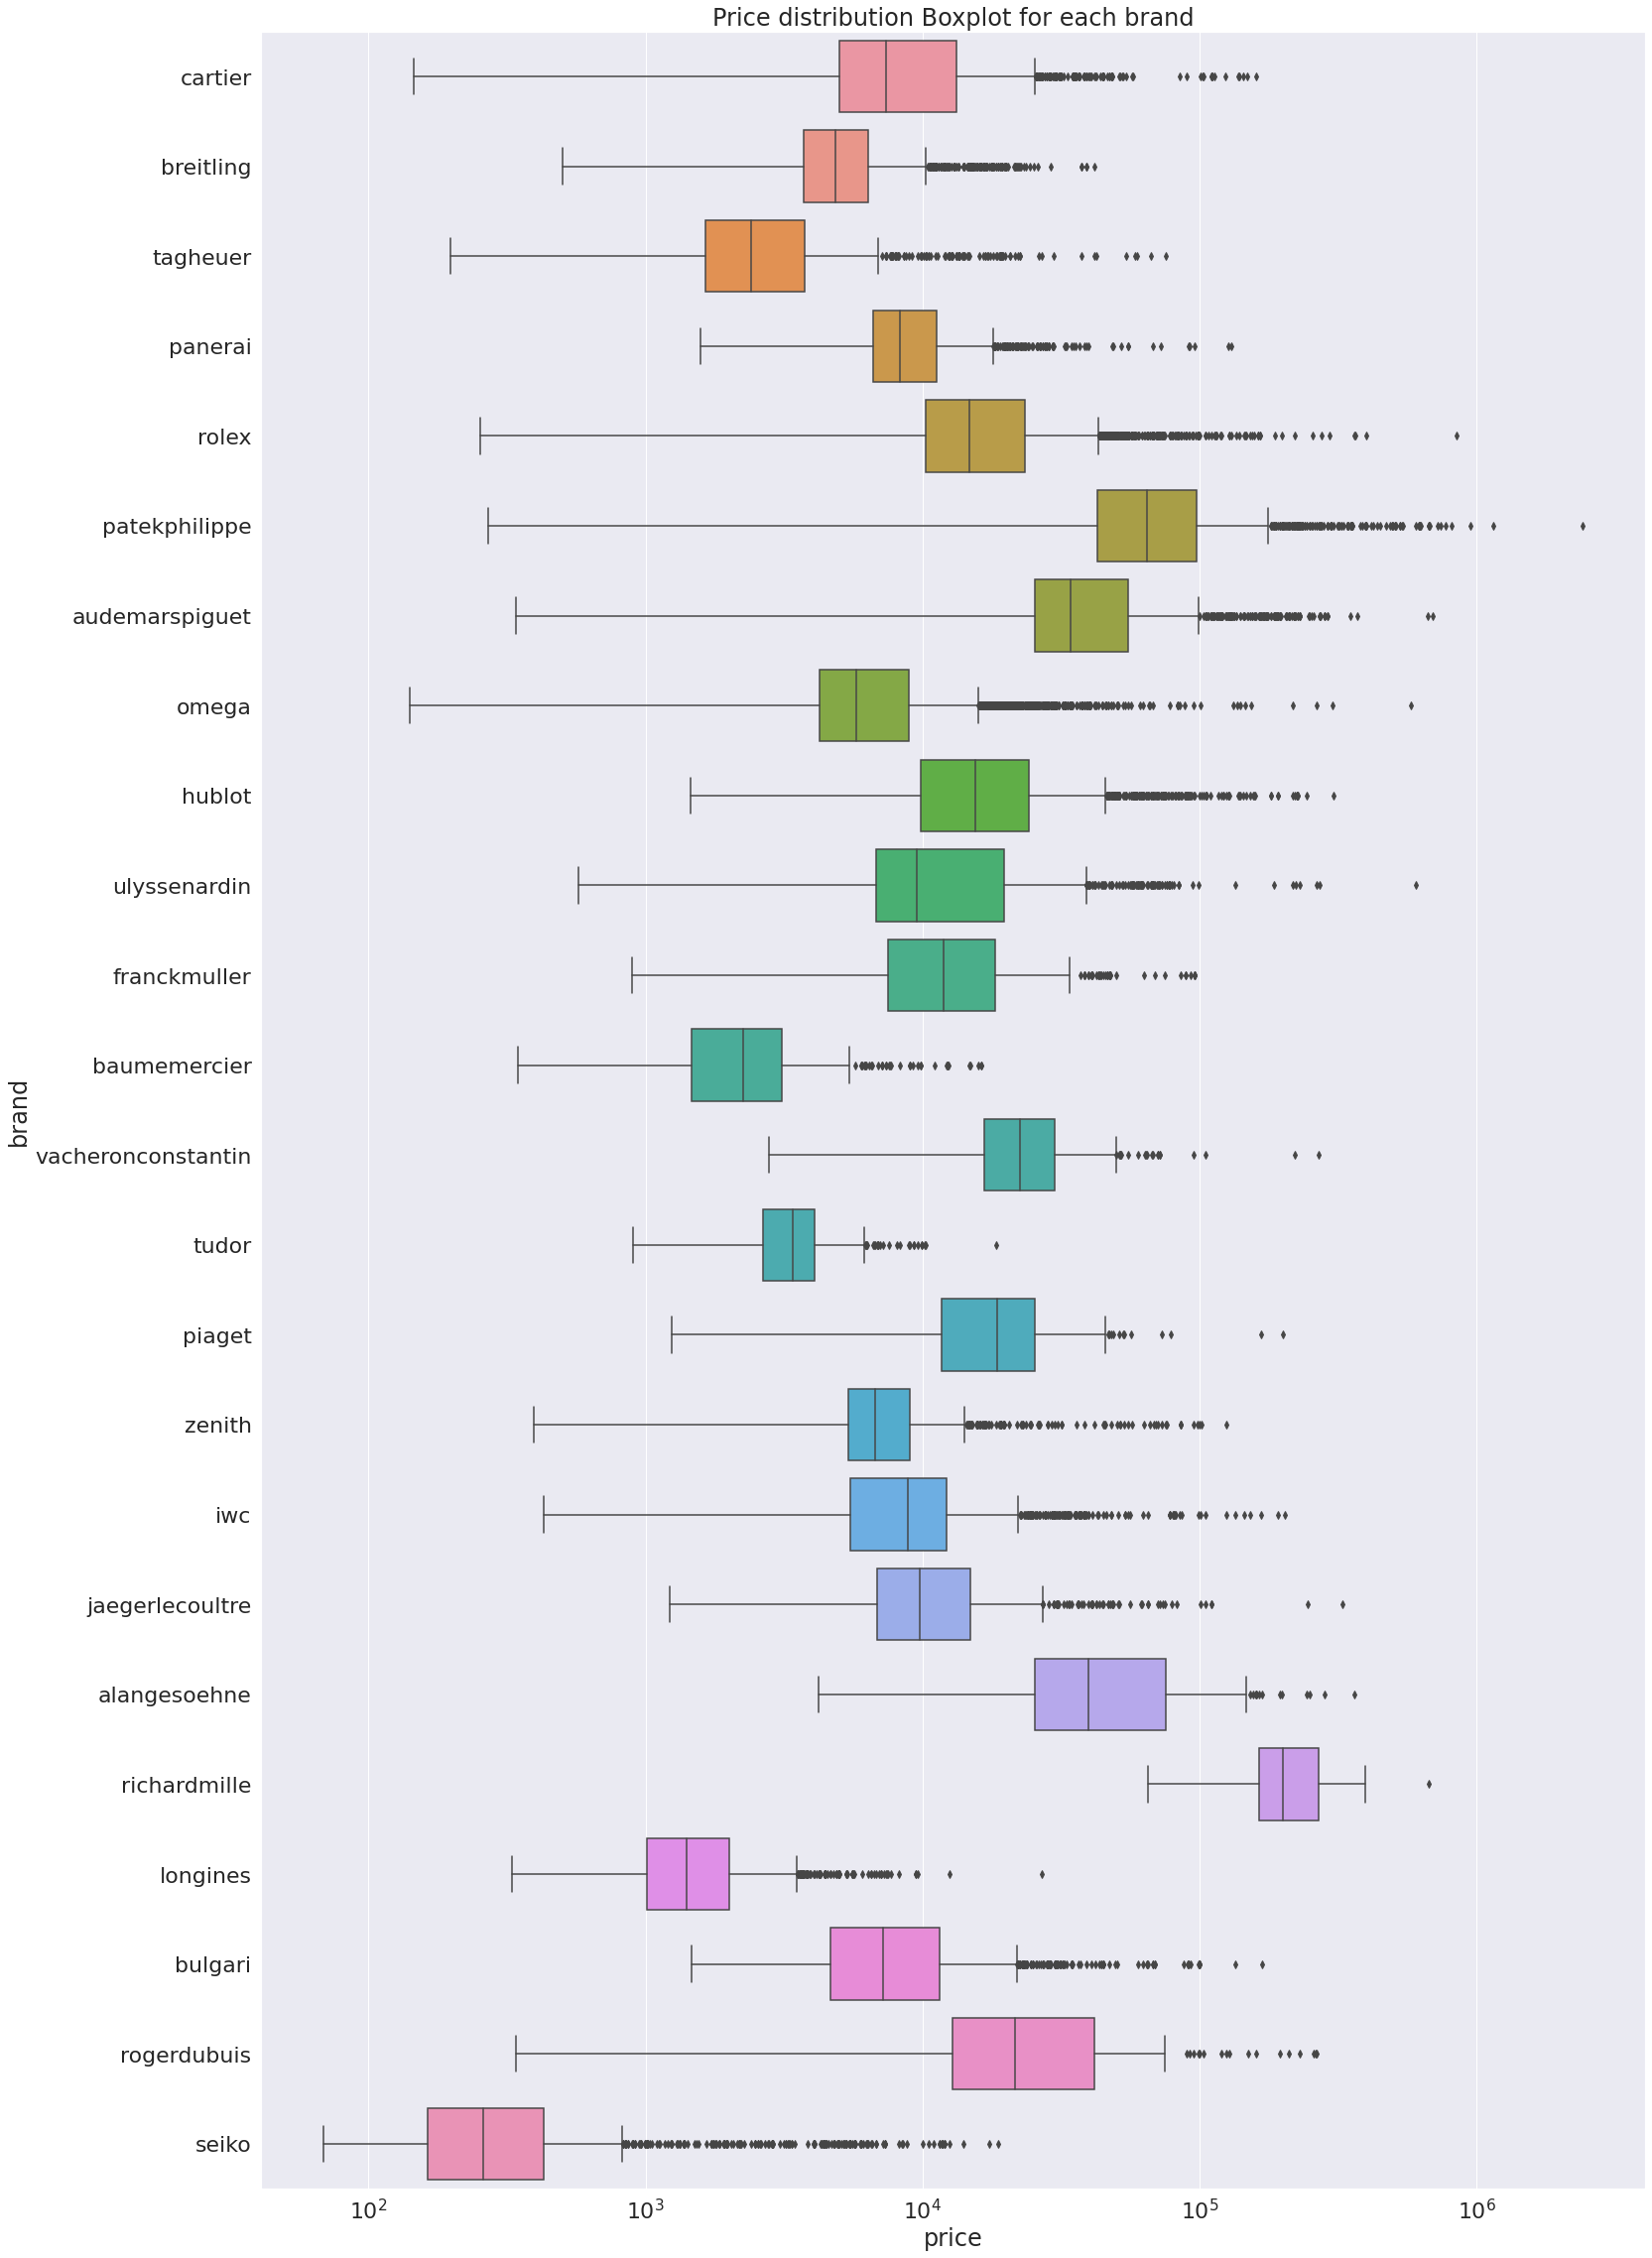

In [124]:
plt.figure(figsize=(25,40))
sns.set(font_scale = 2)
ax = sns.boxplot(y="brand", x="price", data=chrono_df, orient='h')
ax.set_title("Price distribution Boxplot for each brand")
ax.set_xscale("log")

# 7. Is there any relationship between watch year and the average price of the watch for watches between 1950 and 2020? Creating a linear model to predict the price based on the year would be cool

we have a small linear correlation between watch price and year but not enough to accuratly predict the price using only the year and a linear model

In [125]:
chrono_filtered = chrono_df[['price','watch_year']].dropna()

X_year = chrono_filtered.watch_year.values.reshape(-1, 1) 
Y_price = chrono_filtered.price.values.reshape(-1, 1) 


linear_regressor_price = LinearRegression()
linear_regressor_price.fit(X_year, Y_price) 
Y_price_pred = linear_regressor_price.predict(X_year)

In [126]:
linear_regressor_price.score(X_year, Y_price), linear_regressor_price.coef_

(4.355440797021437e-06, array([[10.50648693]]))

In [127]:
plt.figure(figsize=(16,6))
plt.scatter(X_year, Y_price, s=0.3)
plt.plot(X_year, Y_price_pred, color='green')
plt.yscale('log')
plt.show()

# 8. Create an algorithm to assign the delivery time into the following categories: 0-5 days, 6-10 days, 11-15 days, 16+ days. Use the 'found_on' column as the reference date and the earliest date in the 'delivery' column to calculate the delivery time. Which brands are most readily available? Does the delivery time have a relationship with price?

In [128]:
chrono_dates_df = chrono_df[chrono_df.delivery.notna()] 
chrono_dates_df.early_delivery = pd.to_datetime(chrono_dates_df.delivery.apply(lambda x: x.split(' - ')[0]))
chrono_dates_df['delivery_delta'] = chrono_dates_df.early_delivery - chrono_dates_df.found_on


In [129]:
bins = [pd.Timedelta(days = 0),
        pd.Timedelta(days = 5),
        pd.Timedelta(days = 10),
        pd.Timedelta(days = 15),
        chrono_dates_df.delivery_delta.max()]

labels = ['0-5 days', '5-10 days', '10-15 days', '16+ days']
chrono_dates_df['delivery_time_cat'] = pd.cut(chrono_dates_df.delivery_delta, bins, labels = labels)

chrono_dates_df.head()

condition                    delivery            found_on  \
0       New  Jan 8, 2020 - Jan 20, 2020 2019-12-23 16:06:17   
1    Unworn  Jan 8, 2020 - Jan 20, 2020 2019-12-23 16:06:19   
2    Unworn  Jan 8, 2020 - Jan 20, 2020 2019-12-23 16:06:19   
3    Unworn  Jan 8, 2020 - Jan 20, 2020 2019-12-23 16:06:19   
4    Unworn  Jan 8, 2020 - Jan 20, 2020 2019-12-23 16:06:19   

                    model    price     seller  \
0                  Santos   3735.0  12enpunto   
1  Exospace B55 Connected   5648.0  12enpunto   
2          Chrono Cockpit   2598.0  12enpunto   
3         Tank Américaine  11885.0  12enpunto   
4                     NaN   1698.0  12enpunto   

                                seller_url  \
0  chrono24.com/dealer/12enpunto/index.htm   
1  chrono24.com/dealer/12enpunto/index.htm   
2  chrono24.com/dealer/12enpunto/index.htm   
3  chrono24.com/dealer/12enpunto/index.htm   
4  chrono24.com/dealer/12enpunto/index.htm   

                                    title  \
0  Cartier W20066D6 Santos Lady Automatic   
1        Breitling Exospace B55 Connected   
2                       Breitling Cockpit   
3         Cartier W2605456 Tank Americano   
4                     Breitling Windrider   

                                                 url  watch_year  \
0  https://www.chrono24.com/cartier/w20066d6-sant...         NaN   
1  https://www.chrono24.com/breitling/exospace-b5...      2018.0   
2  https://www.chrono24.com/breitling/cockpit--id...      2005.0   
3  https://www.chrono24.com/cartier/w2605456-tank...         NaN   
4  https://www.chrono24.com/breitling/windrider--...         NaN   

                                              raw      brand reference  \
0      Cartier W20066D6 Santos Lady Automatic nan    cartier      None   
1  Breitling Exospace B55 Connected VB5510H2/BE45  breitling      None   
2                    Breitling Cockpit A13358A596  breitling      None   
3                 Cartier W2605456 Tank Americano    cartier      None   
4                      Breitling Windrider B10050  breitling    B10050   

    delivery_delta delivery_time_cat  
0 15 days 07:53:43          16+ days  
1 15 days 07:53:41          16+ days  
2 15 days 07:53:41          16+ days  
3 15 days 07:53:41          16+ days  
4 15 days 07:53:41          16+ days

In [130]:
chrono_dates_df.groupby(['brand'])[['delivery_delta','price']].mean(numeric_only=False)

delivery_delta          price
brand                                                       
alangesoehne        9 days 20:00:18.048484848   62404.684211
audemarspiguet     10 days 00:43:03.634971282   54113.899602
baumemercier       12 days 13:27:25.427471116    2601.275773
breitling          10 days 08:24:15.241765704    5418.587707
bulgari            11 days 09:23:15.261538461   10888.789750
cartier            11 days 04:39:04.931034482   11678.987928
franckmuller       11 days 10:34:27.003039513   17324.556634
hublot             13 days 04:45:44.152313167   20596.994887
iwc                   12 days 07:17:16.919200   12263.386861
jaegerlecoultre    15 days 00:08:07.803220035   15086.629562
longines           10 days 13:28:40.259385665    1689.382118
omega              10 days 02:49:42.020911127    7967.813572
panerai            11 days 06:00:07.392136025   10888.600671
patekphilippe       9 days 03:58:38.931962025   91437.013351
piaget             12 days 11:21:28.898648648   20819.035842
richardmille          11 days 16:45:43.376000  212184.121212
rogerdubuis         9 days 15:04:22.517006802   39201.724138
rolex              10 days 10:17:28.368050364   19521.123560
seiko               9 days 14:37:33.059854014     752.448755
tagheuer           11 days 19:05:21.425147347    2970.169425
tudor              10 days 07:32:42.394117647    3595.574213
ulyssenardin       13 days 01:06:46.032467532   17594.205128
vacheronconstantin 12 days 11:29:51.663677130   25543.192488
zenith             11 days 07:39:38.196950444    9792.242931

In [131]:
chrono_filtered = chrono_dates_df[['price','delivery_delta']].dropna()

X_delivery = chrono_filtered.delivery_delta.dt.days.values.reshape(-1, 1) 
Y_price = chrono_filtered.price.values.reshape(-1, 1) 


linear_regressor_delivery = LinearRegression()
linear_regressor_delivery.fit(X_delivery, Y_price) 
Y_price_pred = linear_regressor_delivery.predict(X_delivery)
linear_regressor_delivery.score(X_delivery, Y_price), linear_regressor_delivery.coef_

(0.0013727931804257132, array([[-166.48635622]]))

we may have a small correlation between price and delivery date but not enough to draw any conclusions or predict the price solely using this linear model 

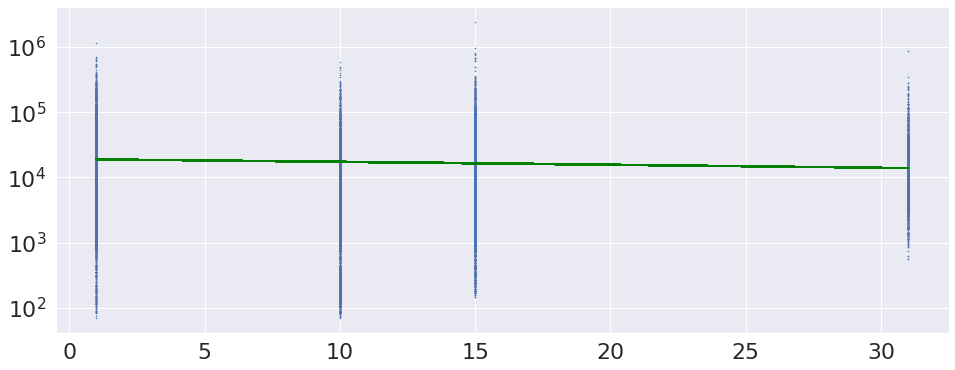

In [132]:
plt.figure(figsize=(16,6))
plt.scatter(X_delivery, Y_price, s=0.3)
plt.plot(X_delivery, Y_price_pred, color='green')
plt.yscale('log')
plt.show()

While this plot looks unsual we actually only have 4 unique delivery days in this dataset 

In [133]:
chrono_dates_df['delivery_delta'].dt.days.unique()

array([15, 10,  1, 31])